# Solve a Simple ODE System


We consider the simple system of two equations,
$$
\frac{dy_1}{dt} = y_2, \qquad \frac{dy_2}{dt} = - y_1, \qquad \text{where} \quad t \in [0,10],
$$
with initial conditions
$$
y_1(0) = 0, \quad y_2(0) = 1.
$$

The exact solution is
$$
y_1 = \sin(t), \quad y_2 = \cos(t).
$$

## Implementation

We begin by importing the necesary modules. Note that `torch` is detected automatically. 


In [1]:
import deepxde as dde
import numpy as np

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


We now define the system of ODEs, where the first argument to `ode_system` is the network input, i.e., the $𝑡$-coordinate,  which we represent as `x`. The second argument to ode_system is the network output, which is a 2-dimensional vector where the first component `y[:, 0:1]` is $𝑦_1$ and the second component `y[:, 1:]` is $𝑦_2.$

We also consider the initial condition, where we need to implement a function that should return `True` for points inside the subdomain and `False` for the points outside. In our case, the point $𝑡$ of the initial condition is $𝑡=0.$ The argument `x` to boundary is the network input and is a $𝑑$-dimensional vector, with  $𝑑=1$ here.
To facilitate the implementation of boundary, a boolean `on_initial` is used as the second argument. If the point $𝑡=0,$. then `on_initial` is `True`, otherwise, `on_initial` is `False`.


In [2]:
def ode_system(x, y):
    """ODE system.
    dy1/dx = y2
    dy2/dx = -y1
    """
    y1, y2 = y[:, 0:1], y[:, 1:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    return [dy1_x - y2, dy2_x + y1]


def boundary(_, on_initial):
    return on_initial


def func(x):
    """
    y1 = sin(x)
    y2 = cos(x)
    """
    return np.hstack((np.sin(x), np.cos(x)))

Now, we define the geometry, the innitial conditions and the data. 

We use 35 training residuall points, 2 training points on thee boundaries, and 100 points for testing the ODE residual.

The argument `solution=func` is the reference solution to compute the error of our solution, and is defined above.

In [3]:
geom = dde.geometry.TimeDomain(0, 10)
ic1 = dde.icbc.IC(geom, lambda x: 0, boundary, component=0)
ic2 = dde.icbc.IC(geom, lambda x: 1, boundary, component=1)
data = dde.data.PDE(geom, ode_system, [ic1, ic2], 35, 2, solution=func, num_test=100)

We now define the network. We use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 50.

In [4]:
layer_size = [1] + [50] * 3 + [2]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

Finally, we define the model, train for 20000 iterations and plot the results.

Compiling model...
'compile' took 0.000413 s

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [6.60e-02, 5.64e-02, 0.00e+00, 1.00e+00]    [6.57e-02, 5.83e-02, 0.00e+00, 1.00e+00]    [1.05e+00]    
1000      [9.25e-03, 7.65e-03, 2.21e-07, 2.51e-04]    [1.02e-02, 7.46e-03, 2.21e-07, 2.51e-04]    [7.63e-01]    
2000      [4.84e-03, 4.10e-03, 8.80e-07, 1.02e-04]    [4.99e-03, 4.36e-03, 8.80e-07, 1.02e-04]    [5.77e-01]    
3000      [2.49e-03, 3.15e-03, 2.02e-06, 4.89e-05]    [2.62e-03, 3.18e-03, 2.02e-06, 4.89e-05]    [4.20e-01]    
4000      [1.65e-03, 2.31e-03, 1.72e-05, 7.83e-06]    [1.72e-03, 1.91e-03, 1.72e-05, 7.83e-06]    [2.86e-01]    
5000      [1.52e-04, 3.51e-04, 4.81e-08, 4.15e-06]    [1.72e-04, 2.59e-04, 4.81e-08, 4.15e-06]    [9.61e-02]    
6000      [2.09e-05, 7.38e-05, 2.88e-08, 1.69e-07]    [2.35e-05, 5.54e-05, 2.88e-08, 1.69e-07]    [2.68e-02]    
7000      [1.44e-04, 1.65e-04, 

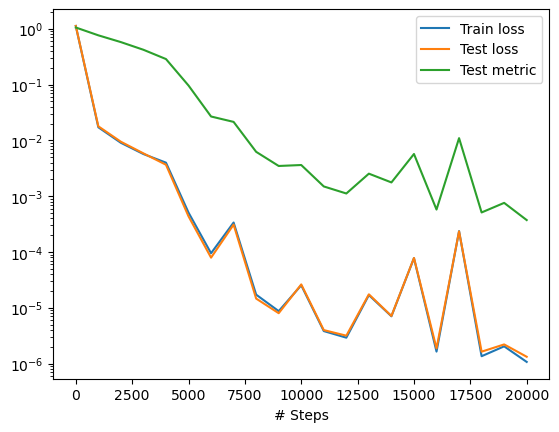

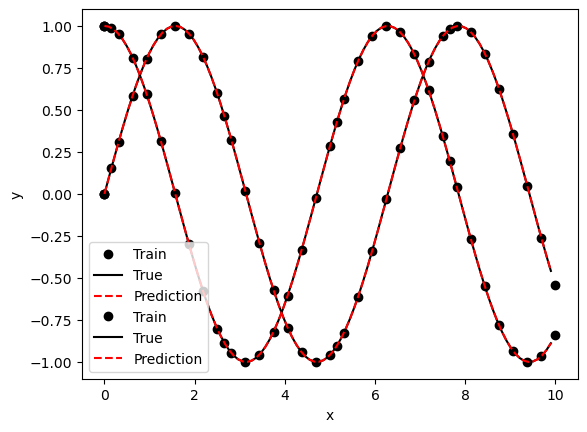

In [5]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)